In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import matplotlib.gridspec as gridspec
from scipy.sparse import diags, kron, block_diag
from scipy.sparse.linalg import spsolve, eigsh

def fun4(x, p, dt, eps ,k):
    return x + dt*((eps**2*k+2)*(p+x)-3*p+p**3)

def check_continuity(points, tol):
    diff = np.diff(np.array(points), axis=0)
    return all(dp < eps for dp in diff)

def check_is_decreasing(points):
    if all(p_current > p_next \
           for p_current, p_next \
           in zip(points, points[1:])):
        return True
    else:
        return False
    
def set_Laplacian2D(Nx, h, BC='periodic'):
    """Set the 2D discrete laplacian by central difference:
        Neumann boundary laplacian is discreted by 
        
        x-direction : u_{-1,j,k}=u_{0,j,k} and
                      u_{Nx+1,j,k}=u_{0,j,k}
                          
        y-direction : u_{i,-1,k}=u_{i,0,k} and
                      u_{i,Nx+1,k}=u_{i,0,k}
            
        Built by two block matries and two off-diagnoals, 
        corner block (corB), central block (cenB)
            
        The diagonal block is [corB, cenB, ..., cenB, corB]
        The off-diagnoals are diagonals line below (above) 
        the main diagonal by Nx positions, all consisting of 1.
            
        L = diagonal block + off-diagonals

    Parameters
    ----------
    Nx : int
        The number of mesh grids.
    h : float
        The mesh size.
    BC : str
        The boundary condition. (default is 'periodic')
        possible options : 'periodic', 'nuemann'

    Returns
    -------
    2D array
        The discrete laplacian with certain boundary.
        
    """
    if BC == 'periodic':
        diag = np.ones(Nx)
        L = diags([diag, -2*diag, diag, 1, 1], \
                  [-1, 0, 1 , -Nx+1, Nx-1], shape=(Nx, Nx))
        I = diags(diag, shape=(Nx, Nx))
    
        L = kron(L, I) + kron(I, L)
        
    elif BC == 'neumann':
        # bulid the block
        diag_cor = 3*np.ones(Nx)
        diag_cor[0] = diag_cor[-1] = 2

        diag_cen = 4*np.ones(Nx)
        diag_cen[0] = diag_cen[-1] = 3

        off_I = diags([np.ones(Nx**2), np.ones(Nx**2)], \
                      [Nx,-Nx], shape=(Nx**2, Nx**2))

        corB = diags([np.ones(Nx), -diag_cor, np.ones(Nx)], \
                     [-1, 0, 1], shape=(Nx, Nx))

        cenB = diags([np.ones(Nx), -diag_cen, np.ones(Nx)], \
                     [-1, 0, 1], shape=(Nx, Nx))

        diagBs = [cenB for i in range(Nx-2)]
        diagBs = tuple([corB]+diagBs+[corB])

        L = block_diag(diagBs) + off_I
        
    return L / h**2

def set_eps(m, h):
    return h*(m+1)/4/np.sqrt(2)/np.arctanh(0.8)

In [3]:
def set_xi(p, eps, dt, k):
    coef = eps**2*k
    xi = -dt*((coef-1)*p + p**3)
    xi = xi/(1+dt*(coef-2))
    return xi

critcal point condition:  True
0.99934464
1e-08
1.52587890625e-05
dt:  False


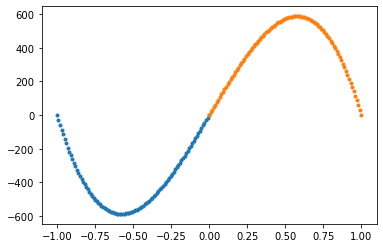

In [198]:
Nx = 128
h = 1/Nx
k = 4/h**2
eps = 0.0001
cp = np.sqrt(12*(1-eps**2*k))/6

dt = 0.5
print('critcal point condition: ', eps**2<1/k)
print(1-eps**2*k)
print(eps**2)
print(1/k)
print('dt: ',dt<-1/(eps**2*k*(cp+1)+cp**3-cp-2))

pos_roots = [set_xi(p, eps, dt,k) for p in test_data_set['pos_p']]
neg_roots = [set_xi(p, eps, dt,k) for p in test_data_set['neg_p']]

plt.plot(neg_p, neg_roots,'.')
plt.plot(pos_p, pos_roots,'.')

In [257]:
# eps = 0.0014
# dt= 0.1
eps = 0.0017
print(1/k)
print(eps**2)
print(1/k>eps**2)

1.52587890625e-05
2.89e-06
True


In [227]:
(dt**2+3)/dt**2/eps**2

30099.99999999999

In [189]:
h= 1/128
eps = 0.015
dt = 0.01
h = 1/128
h**2 > dt*2*eps**2
print(set_xi(-1, 0.0001, 0.01, k))

6.687302218465427e-06


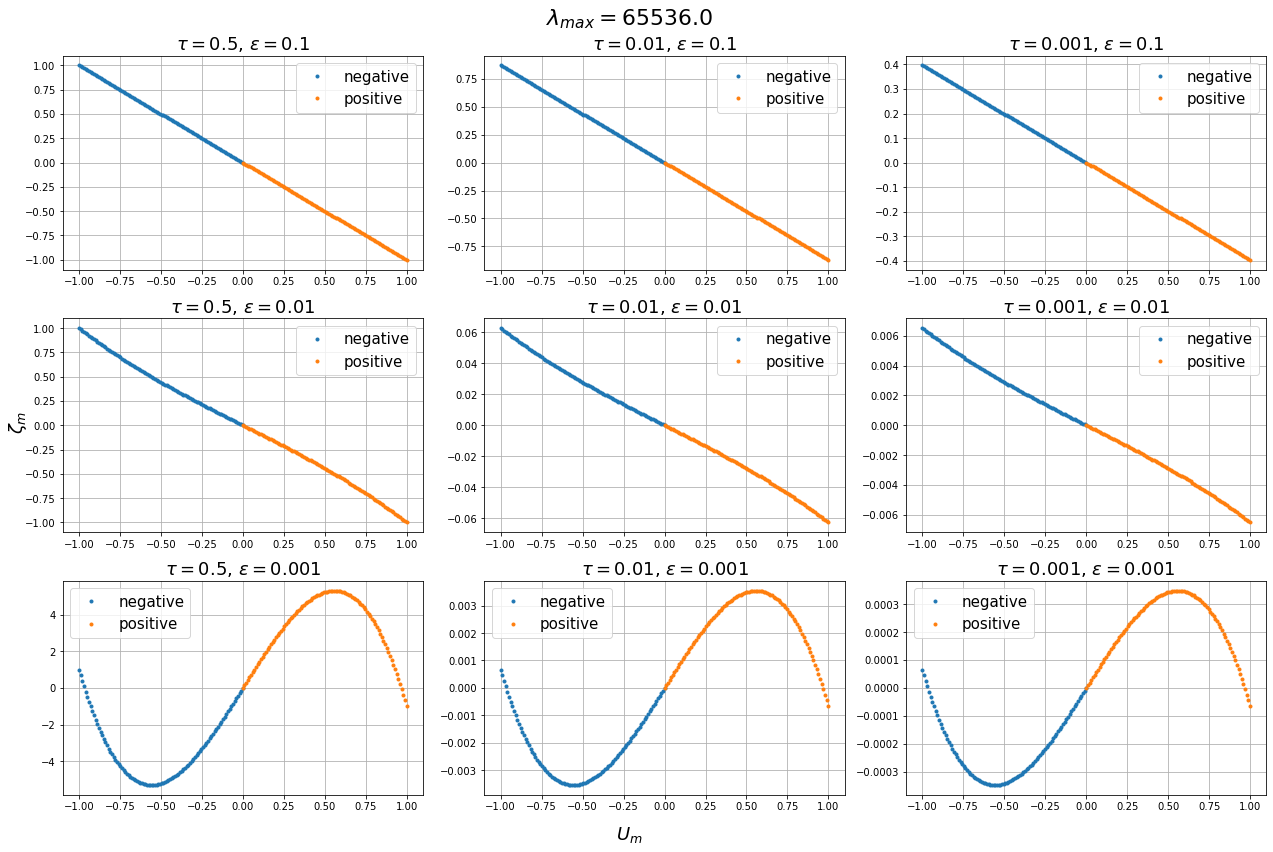

In [199]:
pos_p = np.linspace(0,1,100)
neg_p = np.linspace(-1,0,100)

L = 1
# determine the number of point in x or y direction
Nx = 128

# compute the mesh size
h = 1/Nx
Lap = set_Laplacian2D(Nx, h)
# k = eigsh(-Lap,return_eigenvectors=False,k=1)[0]
# k = np.max(np.real(k))
# eps = set_eps(1, h)/8
k = 4/h**2
# k = 0.01
# k=10

test_data_set = {
    'dt': [0.5, 0.01, 0.001],
#     'eps': [0.1, 0.015, 0.001],
#     'dt': [1, 0.001, 0.01],
    'eps': [0.1, 0.01, 0.001],
    'pos_p': pos_p,
    'neg_p': neg_p
}


fun_plot = plt.figure(figsize=(18,12))
fun_plot_space = gridspec.GridSpec(3, 3, figure=fun_plot)
gs_idx = [(0,0), (1,0), (2,0), (0,1), (1,1), (2,1), \
          (0,2), (1,2), (2,2)]

i = 0
for dt in test_data_set['dt']:
    for eps in test_data_set['eps']:
        
#         pos_roots = [fsolve(fun4, p, args=(p, dt, eps, k)) for p in test_data_set['pos_p']]
#         neg_roots = [fsolve(fun4, p, args=(p, dt, eps, k)) for p in test_data_set['neg_p']]
        pos_roots = [set_xi(p, eps, dt,k) for p in test_data_set['pos_p']]
        neg_roots = [set_xi(p, eps, dt,k) for p in test_data_set['neg_p']]
        
        ax = plt.subplot(fun_plot_space[gs_idx[i]])
        ax.plot(neg_p, neg_roots,'.')
        ax.plot(pos_p, pos_roots,'.')
        ax.legend(['negative', 'positive'], prop={'size': 15})
        ax.set_title(rf'$\tau=${dt}, $\epsilon=${eps}', fontsize=18)
        ax.grid()
        i = i+1
#         print(f"dt: {dt}, eps: {eps}")
#         print("If U_k = -1 xi is ", neg_roots[0])
#         print("If U_k = 1, xi is ", pos_roots[-1])


fun_plot.suptitle(r"$\lambda_{max}=$"+f"{k}", fontsize= 22)
fun_plot.supxlabel(r'$U_{m}$', fontsize= 18)
fun_plot.supylabel(r"$\zeta_{m}$", fontsize= 18)
plt.tight_layout(rect=(0,0,1,1))
plt.show()

In [36]:
k, _ = eigs(-Lap)
print(k)

[131052.26178207+0.j 130993.05901786+0.j 131022.66039997+0.j
 131022.66039997+0.j 130973.34457548+0.j 130973.34457548+0.j]


In [3]:
region_dict = {
    'green': [],
    'red': [],
    'yellow': []
}

pos_p = np.linspace(0,1,100)
neg_p = np.linspace(-1,0,100)

Nx = 128
k = 4*Nx**2

test_data_set = {
    'dt': [0.5,0.4,0.3,0.2, 0.1, 0.01, 0.001, 0.0001],
    'eps': [0.5,0.4,0.3,0.2, 0.1, 0.01, 0.001, 0.0001],
    'dt': np.arange(0.4, 0.6, step=0.01),
    'eps': np.arange(0.0001, 0.005+0.0002, step=0.0002),
    'pos_p': pos_p,
    'neg_p': neg_p
}

for dt in test_data_set['dt']:
    for eps in test_data_set['eps']:
        if (eps**2<1/k) == False:
            region_dict['yellow'].append((dt, eps))
            continue
        else:
            cp = np.sqrt(12*(1-eps**2*k))/6
        
        if (dt <-1/(eps**2*k*(cp+1)+cp**3-cp-2))==True:
            region_dict['green'].append((dt, eps))
        else:
            region_dict['red'].append((dt, eps))
        

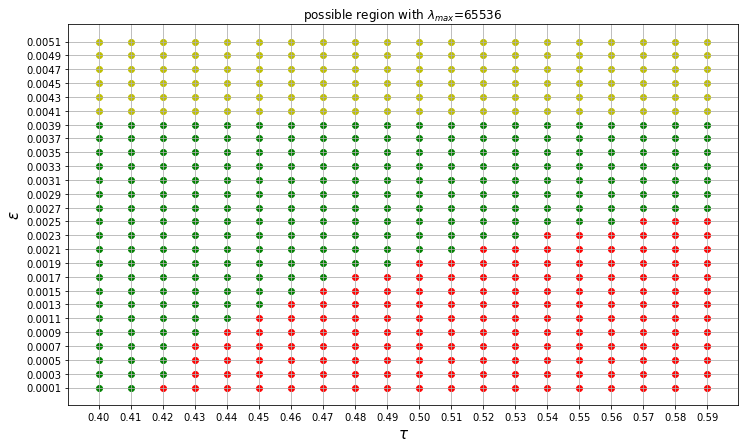

In [4]:
plt.figure(figsize=(12,7))
plt.scatter(*zip(*region_dict['green']), color='g', marker='o')
plt.scatter(*zip(*region_dict['red']), color='r', marker='o')
plt.scatter(*zip(*region_dict['yellow']), color='y', marker='o')
plt.grid()
plt.xlabel(r'$\tau$', fontsize=15)
plt.ylabel(r'$\epsilon$', fontsize=15)
plt.yticks(np.arange(0.0001, 0.005+0.0002, step=0.0002))
plt.xticks(np.arange(0.4, 0.6, step=0.01))
plt.title(r'possible region with $\lambda_{max}$=' + f'{k}')
plt.show()

In [17]:
region_dict = {
    'green': [],
    'red': [],
    'yellow': []
}


pos_p = np.linspace(0,1,100)
neg_p = np.linspace(-1,0,100)

L = 10
# determine the number of point in x or y direction
Nx = 2**7

# compute the mesh size
h = L / (Nx - 1)
k = 4/h**2


test_data_set = {
    'dt': np.arange(0.001,0.1,  step=0.005),
    'eps': np.arange(0.001,0.1,  step=0.005),
    'pos_p': pos_p,
    'neg_p': neg_p
}

tol = 1

for dt in test_data_set['dt']:
    for eps in test_data_set['eps']:
        
        pos_roots = [fsolve(fun4, p, args=(p, dt, eps, k)) for p in test_data_set['pos_p']]
        neg_roots = [fsolve(fun4, p, args=(p, dt, eps, k)) for p in test_data_set['neg_p']]
        
        roots = neg_roots + pos_roots[1:]
#         print('dt, eps: ', dt, eps)
        if check_is_decreasing(roots) == True:
            region_dict['yellow'].append((dt, eps))
        if max(np.abs(roots)) > 1.1:
            region_dict['red'].append((dt, eps))
#             print('large then 1')
#             print('max: ', max(np.abs(roots)))
        if check_continuity(roots, tol) == False:
            region_dict['red'].append((dt, eps))
#             print('not continue')
        else:
            region_dict['green'].append((dt, eps))
#             print('green')
        
#         print('dt, eps: ', dt, eps)
#         plt.plot(roots)
#         plt.show()

C:\Users\user\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [20]:
np.arange(0.001,0.1,  step=0.005)

array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026, 0.031, 0.036, 0.041,
       0.046, 0.051, 0.056, 0.061, 0.066, 0.071, 0.076, 0.081, 0.086,
       0.091, 0.096])

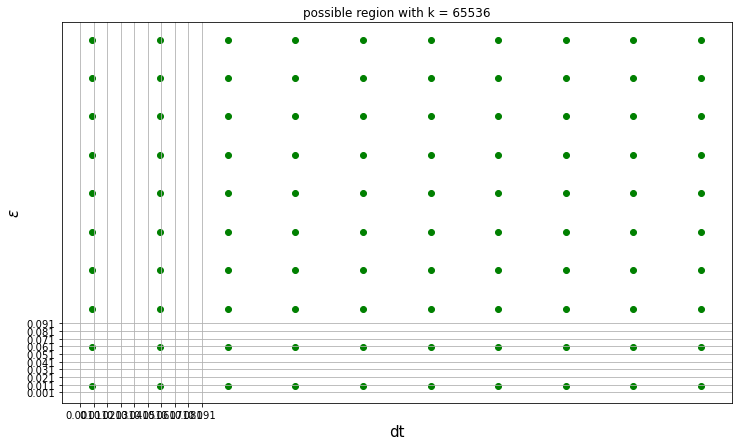

In [33]:
plt.figure(figsize=(12,7))
plt.scatter(*zip(*region_dict['green']), color='g', marker='o')
# plt.scatter(*zip(*region_dict['red']), color='r', marker='o')
# plt.scatter(*zip(*region_dict['yellow']), color='y', marker='o')
plt.grid()
plt.xlabel('dt', fontsize=15)
plt.ylabel(r'$\epsilon$', fontsize=15)
# plt.ylim(0,1)
# plt.xlim(0,1)
plt.yticks(np.arange(0.001, 0.1, step=0.01))
plt.xticks(np.arange(0.001, 0.1, step=0.01))
plt.title(f'possible region with k = {k}')
plt.show()

In [202]:
import html

encoded_text = " &#36984;&#20462;"
decoded_text = html.unescape(encoded_text)
print(decoded_text)


 選修
